In [1]:
import torch
from dalle2_pytorch import CLIP

/Users/yannickaaron/Documents/GitHub/Dalle-2-M1/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
torch.cuda.is_available()

False

In [4]:
CPU = False
device = "cpu" if CPU else torch.device("mps")

In [10]:
clip = CLIP(
    dim_text=512,
    dim_image=512,
    dim_latent=512,
    num_text_tokens=49408,
    text_enc_depth=1,
    text_seq_len=256,
    text_heads=8,
    visual_enc_depth=1,
    visual_image_size=256,
    visual_patch_size=32,
    visual_heads=8,
    use_all_token_embeds=True,  # whether to use fine-grained contrastive learning (FILIP)
    decoupled_contrastive_learning=True,  # use decoupled contrastive learning (DCL) objective function, removing positive pairs from the denominator of the InfoNCE loss (CLOOB + DCL)
    extra_latent_projection=True,  # whether to use separate projections for text-to-image vs image-to-text comparisons (CLOOB)
    use_visual_ssl=True,  # whether to do self supervised learning on images
    visual_ssl_type="simclr",  # can be either 'simclr' or 'simsiam', depending on using DeCLIP or SLIP
    use_mlm=False,  # use masked language learning (MLM) on text (DeCLIP)
    text_ssl_loss_weight=0.05,  # weight for text MLM loss
    image_ssl_loss_weight=0.05,  # weight for image self-supervised learning loss
).cpu()

In [13]:
text = torch.randint(0, 49408, (4, 256)).cpu()
images = torch.randn(4, 3, 256, 256).cpu()

# train

loss = clip(text, images, return_loss=True)  # needs to be set to True to return contrastive loss

loss.backward()

In [15]:
import torch
from dalle2_pytorch import CLIP, Decoder, Unet

# trained clip from step 1

clip = CLIP(
    dim_text=512,
    dim_image=512,
    dim_latent=512,
    num_text_tokens=49408,
    text_enc_depth=1,
    text_seq_len=256,
    text_heads=8,
    visual_enc_depth=1,
    visual_image_size=256,
    visual_patch_size=32,
    visual_heads=8,
).cpu()

# unet for the decoder

unet = Unet(dim=128, image_embed_dim=512, cond_dim=128, channels=3, dim_mults=(1, 2, 4, 8)).cpu()

# decoder, which contains the unet and clip

decoder = Decoder(unet=unet, clip=clip, timesteps=100, image_cond_drop_prob=0.1, text_cond_drop_prob=0.5).cpu()

# mock images (get a lot of this)

images = torch.randn(4, 3, 256, 256).cpu()

# feed images into decoder

loss = decoder(images)
loss.backward()

In [20]:
import torch
from dalle2_pytorch import CLIP, DALLE2, Decoder, DiffusionPrior, DiffusionPriorNetwork, Unet

clip = CLIP(
    dim_text=512,
    dim_image=512,
    dim_latent=512,
    num_text_tokens=49408,
    text_enc_depth=6,
    text_seq_len=256,
    text_heads=8,
    visual_enc_depth=6,
    visual_image_size=256,
    visual_patch_size=32,
    visual_heads=8,
).cpu()

# mock data

text = torch.randint(0, 49408, (4, 256)).cpu()
images = torch.randn(4, 3, 256, 256).cpu()

# train

loss = clip(text, images, return_loss=True)

loss.backward()

# do above for many steps ...

# prior networks (with transformer)

prior_network = DiffusionPriorNetwork(dim=512, depth=6, dim_head=64, heads=8).cpu()

diffusion_prior = DiffusionPrior(net=prior_network, clip=clip, timesteps=1000, sample_timesteps=64, cond_drop_prob=0.2).cpu()

loss = diffusion_prior(text, images)
loss.backward()

# do above for many steps ...

# decoder (with unet)

unet1 = Unet(
    dim=128,
    image_embed_dim=512,
    text_embed_dim=512,
    cond_dim=128,
    channels=3,
    dim_mults=(1, 2, 4, 8),
    cond_on_text_encodings=True,  # set to True for any unets that need to be conditioned on text encodings
).cpu()

unet2 = Unet(dim=16, image_embed_dim=512, cond_dim=128, channels=3, dim_mults=(1, 2, 4, 8, 16)).cpu()

decoder = Decoder(
    unet=(unet1, unet2), image_sizes=(128, 256), clip=clip, timesteps=100, image_cond_drop_prob=0.1, text_cond_drop_prob=0.5
).cpu()

for unet_number in (1, 2):
    loss = decoder(
        images, text=text, unet_number=unet_number
    )  # this can optionally be decoder(images, text) if you wish to condition on the text encodings as well, though it was hinted in the paper it didn't do much
    loss.backward()

# do above for many steps

dalle2 = DALLE2(prior=diffusion_prior, decoder=decoder)

images = dalle2(
    ["cute puppy chasing after a squirrel"],
    cond_scale=2.0,  # classifier free guidance strength (> 1 would strengthen the condition)
)

sampling loop time step: 100%|██████████| 100/100 [01:32<00:00,  1.08it/s]
2it [03:43, 111.68s/it]


In [41]:
images[0][0].size()

torch.Size([256, 256])

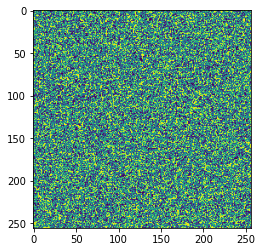

In [46]:
# save the images
plt.imshow(images[0][2])

TypeError: Invalid shape (3, 256, 256) for image data

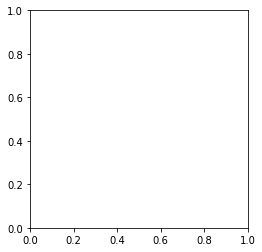

In [36]:
npimg = images.numpy()
plt.imshow(npimg[0])

In [32]:
import matplotlib.pyplot as plt
import numpy as np


def myimshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
# function to calulate the sum of 2,3,4,1,2,4
def sum_of_digits(x):
    return x % 10 + x // 10 % 10 + x // 100 % 10 + x // 1000 % 10 + x // 10000 % 10 + x // 100000 % 10

In [ ]:
.to(device)

In [16]:
torch.device("mps")

device(type='mps')

In [17]:
cpu()

NameError: name 'cpu' is not defined

In [18]:
CLIP.device = "mps"

In [19]:
CLIP.device

'mps'